# Методы оптимизации
## Лабораторная работа № 3

In [2]:
import inspect
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
sns.set()

Populating the interactive namespace from numpy and matplotlib


In [3]:
pylab.rcParams['figure.figsize'] = (20, 12)

In [4]:
def load_f(name):
    to = []
    with open(name,'r') as f:
        for line in f.readlines():
            if line.strip() == '':
                continue
            to.append(np.array([float(i) for i in line.strip().split(' ') if i != '']))
    return np.array(to)

In [5]:
P2 = load_f("P2.txt").T[2].reshape(1600,1)
P4_V1 = load_f("P4_V1.txt").T[2].reshape(1600,1)
P4_V2 = load_f("P4_V2.txt").T[2].reshape(1600,1)
P4_V3 = load_f("P4_V3.txt").T[2].reshape(1600,1)
P4_V4 = load_f("P4_V4.txt").T[2].reshape(1600,1)

In [6]:
P2.shape,P4_V1.shape,P4_V2.shape,P4_V3.shape,P4_V4.shape

((1600, 1), (1600, 1), (1600, 1), (1600, 1), (1600, 1))

In [7]:
from mpl_toolkits.mplot3d import Axes3D
def plot_3d(p):
    sns.set_context("talk")
    sns.set_style('whitegrid')
    X, Y, Z = p.T[0].reshape(40,40),p.T[1].reshape(40,40),p.T[2].reshape(40,40) 
    ax = plt.axes(projection='3d')
    ax.scatter(X,Y,Z)
    ax.plot_surface(X,Y,Z, cmap=plt.cm.jet, rstride=1, cstride=1, linewidth=0)

In [8]:
def plot_countor(p):
    sns.set_context("talk")
    sns.set_style('whitegrid')
    X, Y, Z = p.T[0].reshape(40,40),p.T[1].reshape(40,40),p.T[2].reshape(40,40)
   
    cp = plt.contour(X, Y, Z, 40,colors='black');
    
    plt.clabel(cp, inline=True, fontsize=16)
    plt.colorbar(cp)
    plt.xlabel('x')
    plt.ylabel('y')

In [9]:
'''P2 = load_f("P2.txt")
P4_V1 = load_f("P4_V1.txt")
P4_V2 = load_f("P4_V2.txt")
P4_V3 = load_f("P4_V3.txt")
P4_V4 = load_f("P4_V4.txt")'''

'P2 = load_f("P2.txt")\nP4_V1 = load_f("P4_V1.txt")\nP4_V2 = load_f("P4_V2.txt")\nP4_V3 = load_f("P4_V3.txt")\nP4_V4 = load_f("P4_V4.txt")'

In [10]:
'''plot_3d(P2)'''


'plot_3d(P2)'

#### Метод перебора

In [11]:
def perebor(f):
    min = f[0][0]
    for i in range(len(f)):
        for j in range(len(f[0])):
            if (f[i][j]<min):
                min = f[i][j]
    print(min)
    
perebor(P2)

0.00225006


#### Метод поиска по шаблону

#### Метод случайного поиска

In [12]:
def random_search(f):
    n = int(f.shape[0]*0.5)
    best_f = f[0][0]
    for i in np.random.permutation(f.shape[0])[:n]:
        for j in np.random.permutation(f.shape[1])[:n]:
            if f[i][j] < best_f:
                best_f = f[i][j]
    return best_f

random_search(P2)

0.00225006

#### Метод имитации отжига

In [13]:
### Больцмановский отжиг
def T_b(k,T0=1e4):
    return T0/np.log(1+k)

def G_b(dx,T,D=2):
    a1 = 1/np.sqrt(2*np.pi*T)**D
    a2 = np.exp(-(dx**2)/(2*T))
    return a1*a2

def h(de,T):
    a = np.exp(-de/T)
    if a is None:
        return 0
    return a
    

In [14]:
### Отжиг Коши
def T_k(k,T0=100):
    return T0/k

def G_k(dx,T,D=2):
    a = T/(dx**2 + T**2)/np.pi
    return a**D
    

In [15]:
### Тушение больцмана
def T_bt(k,c=0.8,T0=1e4):
    return T0*c**k
    

In [16]:
def my_G(dx,a,b):
    return np.random.randint(0,a),np.random.randint(0,b)

In [31]:
def imitation_of_fire(f,a,T=T_bt,G=my_G,h=h,max_iter=10000):
    a0,b0=a
    x,y = int(np.random.rand()*a0),int(np.random.rand()*b0)
    E_o = f(x,y)
    k = 0
    er = max_iter
    a = np.random.rand()
    x_n,y_n=0,0
    while True:
        k += 1
        #x_n,y_n = G(np.array([x,y]),T(k))
        x_n,y_n = G(np.array([x,y]),a0,b0)
        E_n = f(x_n,y_n)
        a = np.random.rand()
        if a < h(E_n-E_o,T(k)) and E_n < E_o:
            E_o = E_n
            x,y = x_n,y_n
            er = max_iter
        else:
            er -= 1
            k -= 1
            if er == 0:
                break
    return E_o

f = lambda x,y: P2[int(x)][int(y)]
a = P2.shape[0],P2.shape[1]
imitation_of_fire(f,a)

0.00225006

#### Генетический алгоритм

In [18]:
def create_new_population(f,a,h=100):
    population = []
    #scores = []
    
    while not len(population) == h:
        new_child = []
        for ai in a:
            new_child.append(np.random.randint(ai))
        
        population.append(np.array(new_child))
        #scores.append(f(*new_child))
    
    #return np.array(population),np.array(np.array(scores))
    #return population,scores
    return population
    
def sort_pop(f,population):
    n = len(population)
    scores = np.zeros(n)
    for i in range(n):
        scores[i] = f(*population[i])
        
    arg_sort = scores.argsort()
    return np.array(population)[arg_sort].tolist()

def arg_sort_pop(f,population):
    n = len(population)
    scores = np.zeros(n)
    for i in range(n):
        scores[i] = f(*population[i])
        
    arg_sort = scores.argsort()
    return arg_sort

def create_new_generation(f,population,a,n_s=100,n_m=0.3,n_c=0.7):
    n = len(population)
    n_c = int(n_c*n)
    n_m = int(n_m*n)
    #n_s = int(n_s*n)
    
    p = np.random.permutation(n)
    for i in range(n_c):
        np.random.shuffle(p)
        p1 = population[p[0]]
        p2 = population[p[1]]
        population += crossingover(p1,p2)
        
    for i in range(n_m):
        mutant_index = p[i]
        population[mutant_index] = mutation(population[mutant_index],a)
    
    return sort_pop(f,population)[:n_s]

def create_new_generation2(f,population,a,n_s=100,n_m=0.3,n_c=0.7):
    n = len(population)
    n_c = int(n_c*n)
    n_m = int(n_m*n)
    #n_s = int(n_s*n)
    
    for i in arg_sort_pop(f,population)[-n_m:]:
        population[i] = mutation(population[i],a)
    
    p = np.random.permutation(n)
    
    for i in range(n_c):
        np.random.shuffle(p)
        p1 = population[p[0]]
        p2 = population[p[1]]
        population += crossingover(p1,p2)
    
    return sort_pop(f,population)[:n_s]
        
def crossingover(p1,p2):
    pop_cross = []
    for i in range(len(p1)):
        for j in range(len(p2)):
            if i != j:
                pn1 = copy(p1)
                pn2 = copy(p2)
                
                pn1[j] = p2[j]
                pn2[i] = p1[i]
                
                pop_cross.append(np.array(pn1))
                pop_cross.append(np.array(pn2))
                
    return pop_cross

def mutation(p,a):
    c = np.random.randint(len(a))
    a = a[c]
    p[c] = np.random.randint(a)
    return p

def genetic(f,a,count_gen=100,h=50):
    p1 = create_new_population(f,a,h=h)
    for i in range(count_gen):
        p1 = create_new_generation(f,p1,a,n_s=int(0.5*h))
            
    return f(*p1[0])

def genetic2(f,a,count_gen=100,h=50):
    p2 = create_new_population(f,a,h=h)

    for i in range(count_gen):
        p2 = create_new_generation2(f,p2,a,n_s=int(0.5*h))
        
    return f(*p2[0])

f = lambda x,y: P2[int(x)][int(y)]
genetic(f,[P2.shape[0],P2.shape[1]])

0.00225006

#### Подбор параметров

#### Генетический алгоритм

100
272
445
618
790
963
1136
1309
1481
1654
1827
2000
Wall time: 16min 41s


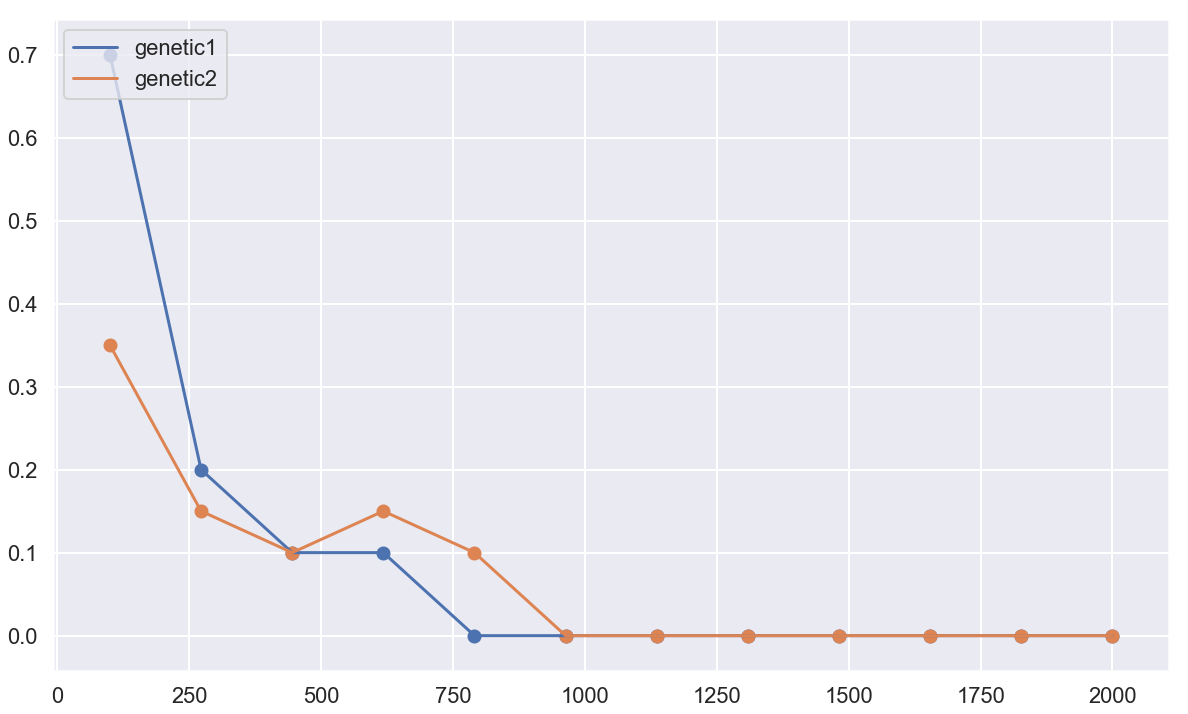

In [24]:
%%time
def test_genetic(f,a,hh,test_ans,max_test=20):
    sns.set_context("poster")
    errors=[[],[]]
    for h in hh:
        err1 = 0
        err2 = 0
        print(int(h))
        for i in range(max_test):
            ans1 = genetic(f,a,h=int(h))-test_ans
            ans2 = genetic2(f,a,h=int(h))-test_ans
            if ans1 != 0:
                err1 +=1
            if ans2 != 0:
                err2 +=1
        errors[0].append(err1/max_test)
        errors[1].append(err2/max_test)
    plt.plot(hh,errors[0],label='genetic1')
    plt.scatter(hh,errors[0])
    plt.plot(hh,errors[1],label='genetic2')
    plt.scatter(hh,errors[1])
    plt.legend(loc='upper left')
    return errors

f = lambda x,y: P2[int(x)][int(y)]
a = [P2.shape[0],P2.shape[1]]
test_ans = np.min(P2)
hh = np.linspace(100,2000,12)

test_genetic(f,a,hh,test_ans)

100
621
1142
1663
2184
2705
3226
3747
4268
4789
5310
5831
6352
6873
7394
7915
8436
8957
9478
10000
Wall time: 29.2 s


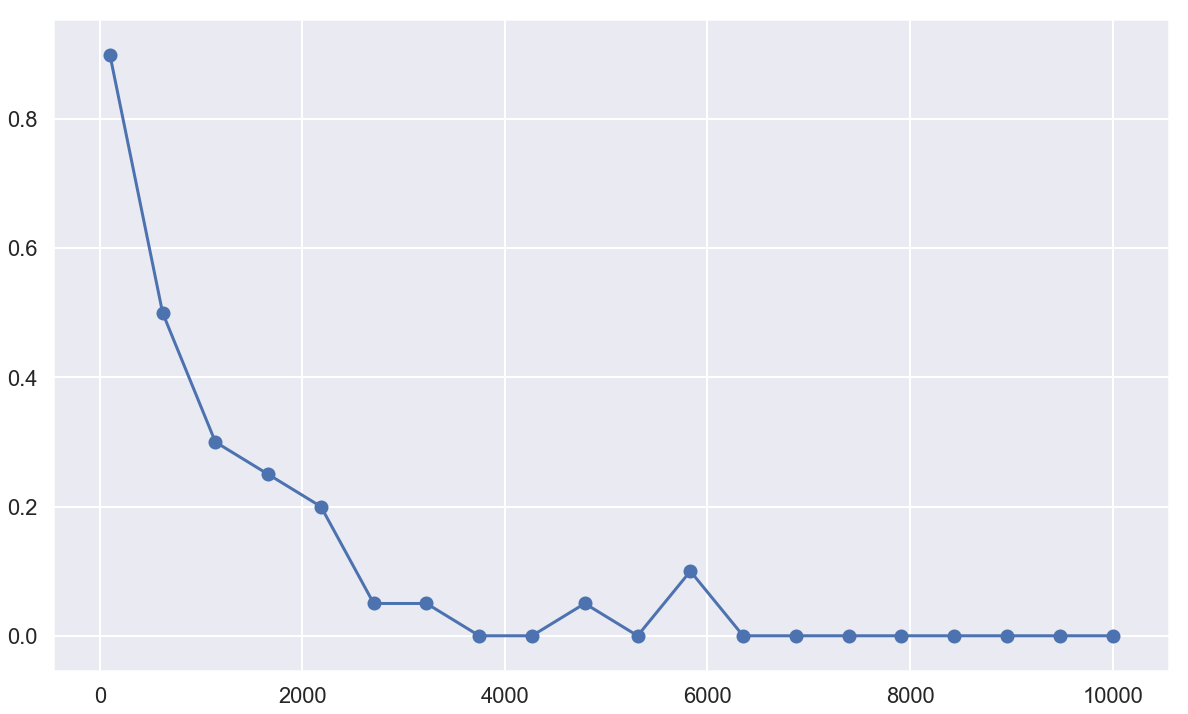

In [36]:
%%time
def test_fire(P2,hh,max_test=20):
    f = lambda x,y: P2[int(x)][int(y)]
    a = [P2.shape[0],P2.shape[1]]
    test_ans = np.min(P2)
    sns.set_context("poster")
    errors=[]
    for h in hh:
        err1 = 0
        print(int(h))
        for i in range(max_test):
            ans1 = imitation_of_fire(f,a,max_iter=int(h))-test_ans
            if ans1 != 0:
                err1 +=1
        errors.append(err1/max_test)
    plt.plot(hh,errors)
    plt.scatter(hh,errors)
    return errors

hh = np.linspace(1e2,1e4,20)

test_fire(P2,hh)

#### Test all

In [20]:
def test(P):
    f = lambda x,y: P[int(x)][int(y)]
    a = [P.shape[0],P.shape[1]]
    return perebor(P),random_search(P),imitation_of_fire(f,a[0],a[1]),genetic(f,a),genetic2(f,a)

In [21]:
test(P2),test(P4_V1),test(P4_V2),test(P4_V3),test(P4_V4)

0.00225006
0.00159419
0.00140179
0.000768731
0.00130828


((None, 0.00251783, 0.00225006, 0.00250048, 0.00284153),
 (None, 0.00159419, 0.00159419, 0.00245682, 0.00235373),
 (None, 0.00149905, 0.00140179, 0.00140179, 0.00157919),
 (None, 0.000768731, 0.000768731, 0.000768731, 0.00229418),
 (None, 0.00130828, 0.00130828, 0.00202447, 0.00130828))

In [22]:
np.min(P2),np.min(P4_V1),np.min(P4_V2),np.min(P4_V3),np.min(P4_V4)

(0.00225006, 0.00159419, 0.00140179, 0.000768731, 0.00130828)